In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from keras.layers import Input, Dense
from keras.models import Model

from thesis.utils.metrics import *

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = True

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 20
MIN_SIZE = 0
NUM_CORES = 16

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL', 'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
SAMPLE_RATIO = 0.01

In [8]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"

In [74]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

save_parent_location = "hdfs://deka.cip.ifi.lmu.de/pg-vectors/"
if IS_SAMPLE: 
    save_parent_location = save_parent_location + "sample_" + str(SAMPLE_RATIO) + "/"


root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "sample_" + str(SAMPLE_RATIO))
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output_training_validation_documents_' + str(SAMPLE_RATIO)

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"
validation_docs_list_file = exports_location + "validation_documents_" + str(SAMPLE_RATIO) + "_sample.pkl"


training_preprocessed_files_prefix = root_location + "training_docs_sample_%s_data_preprocessed-" % str(SAMPLE_RATIO)
training_preprocessed_docids_files_prefix = root_location + "training_docs_sample_%s_docids_preprocessed-" % str(SAMPLE_RATIO)
validation_preprocessed_files_prefix = root_location + "validation_docs_sample_%s_data_preprocessed-" % str(SAMPLE_RATIO)
validation_preprocessed_docids_files_prefix = root_location + "validation_docs_sample_%s_docids_preprocessed-" % str(SAMPLE_RATIO)

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))

CPU times: user 14.9 s, sys: 612 ms, total: 15.5 s
Wall time: 15.5 s


In [41]:
SMALL_SAMPLE_RATIO = 0.0001

validation_small_preprocessed_files_prefix = root_location + "validation_docs_sample_%s_data_preprocessed-" % str(SMALL_SAMPLE_RATIO)
validation_small_preprocessed_docids_files_prefix = root_location + "validation_docs_sample_%s_docids_preprocessed-" % str(SMALL_SAMPLE_RATIO)

validation_small_docs_list_file = exports_location + "validation_documents_" + str(SMALL_SAMPLE_RATIO) + "_sample.pkl"
validation_small_docs_list = pickle.load(open(validation_small_docs_list_file))

In [11]:
len(training_docs_list)

49789

In [12]:
len(validation_docs_list)

12412

In [13]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [14]:
def get_training_vector(classification, term_list, classifications, number_of_terms):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, SparseVector(number_of_terms, term_list))

def train_level_new(docs_index, classification, doc_classification_map, number_of_terms):
    training_vectors = docs_index.map(
        lambda (doc_id, postings): get_training_vector(classification, postings,
                                                        doc_classification_map[doc_id], number_of_terms))
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

def model_exists(path):
    try:
        model = SVMModel.load(sc, path)
        return True;
    except:
        return False
    
def get_training_vector(classification, dense_vector, classifications):
    clss = 1 if classification in classifications else 0
    return LabeledPoint(clss, dense_vector)

def train_level_doc2vec(classification, doc_classification_map):
    doc2vec_model = GLOBAL_VARS.DOC2VEC_MODEL
    training_vectors = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_vectors.append(get_training_vector(classification, normal_array, 
                                                    doc_classification_map[doc_id]))
    info("Finished getting training vectors")
    training_vectors = sc.parallelize(training_vectors)
    info("Finished parallelization")
    svm = SVMWithSGD.train(training_vectors, iterations=SVM_ITERATIONS, convergenceTol=SVM_CONVERGENCE, regParam=SVM_REG)
    return training_vectors, svm

In [15]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)

def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [16]:
def train_classifications(classifications):
    info("====== Doing Training")
    i=0
    for classification in classifications:
        print classification
        try:
            model_path = get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification)
            if not model_exists(model_path):
                training_vectors, svm = train_level_doc2vec(classification, doc_classification_map)
                svm.save(sc, model_path)
            else:
                print "Model Exists"
        except:
            print "Problem creating: %s: %s" % (classification, GLOBAL_VARS.MODEL_NAME)
            raise

In [17]:
def do_validation(validation_vectors_matrix, doc_classification_map, classifications, classifications_name):

    info("====== Doing Validation")
    method = GLOBAL_VARS.MODEL_NAME
    subset = classifications_name

    doc_count = validation_vectors_matrix.shape[0]
    y_score = np.zeros((doc_count, len(classifications)))
    y_true = np.zeros((doc_count, len(classifications)))
    i=0

    for classification in classifications:
        print classification

        validation_vectors = get_validation_doc2vec_spark_vectors(validation_vectors_matrix, 
                                                                  classification, doc_classification_map)
        #global binarySvm
        binarySvm = SVMModel.load(sc, get_svm_model_path(GLOBAL_VARS.MODEL_NAME, classification))
        info("Loaded the model, Doing the prediction now....")
        binarySvm.clearThreshold()
        binarySvmB = sc.broadcast(binarySvm)
        # using the broadcasted binarySvm variable, fixes global name 'binarySvm' is not defined as this variable was not
        # available in the workers, so we pass it explicitly to the mapper using partial
        labels_predictions = validation_vectors.map( \
            partial(lambda svm, p: (p.label, svm.value.predict(p.features)), binarySvmB) \
        ).collect()
        #labels = test_labeled_points.map(lambda p: p.labels)
        y_true[:,i] = [label_pred[0] for label_pred in labels_predictions]
        y_score[:,i] = [label_pred[1] for label_pred in labels_predictions]
        i+=1
    y_binary_score = get_binary(y_score)
    # results[method]["y_true"] = y_true
    # results[method]["y_score"] = y_score
    # results[method]["y_binary_score"] = y_binary_score
    metrics = get_metrics(y_true, y_score, y_binary_score)
    return metrics


In [18]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info("Finished: {}".format(str(i)))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [161]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [20]:
def get_validation_doc2vec_spark_vectors(validation_vectors_matrix, classification, doc_classification_map):
    validation_vectors = []
    for (index, doc_id) in enumerate(validation_docs_list):
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        validation_vector = validation_vectors_matrix[index]
        validation_vectors.append(get_training_vector(classification, validation_vector, 
                                                    doc_classification_map[doc_id]))
    validation_vectors = sc.parallelize(validation_vectors)
    info("Finished getting validation vectors")
    return validation_vectors

In [37]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    training_data = []
    training_labels = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_data.append(normal_array)
        eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
        training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
    training_labels = np.array(training_labels)
    return training_data, training_labels

In [170]:
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

#### Get starting positions in bytes for every line to be able to do random sampling

In [26]:
%%time
line_positions = dict()
with open(training_file) as f:
    
    i = 0
    line_positions[i] = f.tell()
    line = f.readline()
    while line:
        i+=1
        if not line.strip(): continue
        line_positions[i] = f.tell()
        line = f.readline()
    del line_positions[i]

CPU times: user 6.62 s, sys: 592 ms, total: 7.22 s
Wall time: 7.21 s


### Doc2vec and SVM Parameters

In [176]:
DOC2VEC_SIZE = 300
DOC2VEC_WINDOW = 8
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 1
DOC2VEC_MEAN = 0
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 1000 # report the progress every x terms

In [177]:
SVM_ITERATIONS = 100
SVM_CONVERGENCE = 0.001
SVM_REG = 0.001
GLOBAL_VARS.SVM_MODEL_NAME = 'iter_{}_reg_{}'.format(SVM_ITERATIONS, SVM_REG)

In [164]:
NN_HIDDEN_NEURONS = 4500
NN_EPOCHS = 50

## Create the Doc2vec model

In [188]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
placeholder_model_name = placeholder_model_name + "_curriter_{}"
placeholder_model_name

'doc2vec_size_300_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}'

In [189]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [190]:
%%time
training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=training_docs_iterator, progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else:
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2016-12-29 04:29:54,015 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model
2016-12-29 04:29:58,435 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.docvecs.* with mmap=None
2016-12-29 04:29:58,438 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.syn1neg.npy with mmap=None
2016-12-29 04:29:59,748 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/vocab_model/model.syn0.npy with mmap=None
2016-12-29 04:29:59,767 : INFO : setting ignored attribute syn0norm to None
2016-12-29 04:29:59,768 : INFO : setting ignored attribute cum_table to None
2016-12-29 04:30:00,162 : INFO : using concatenative 5100-dimensional layer1
2016-12-29 04:30:00,164 : INFO : resetting layer weights


CPU times: user 7.6 s, sys: 2.4 s, total: 9.99 s
Wall time: 9.75 s


In [160]:
vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
dd = sorted(vocab_counts, key=vocab_counts.get)

## Actual Training, validation and Metrics Loop

In [191]:
doc2vec_model.min_alpha = 0.025
epoch_metrics = []
word2vec_results = []
classifications = sections

<IPython.core.display.Javascript object>


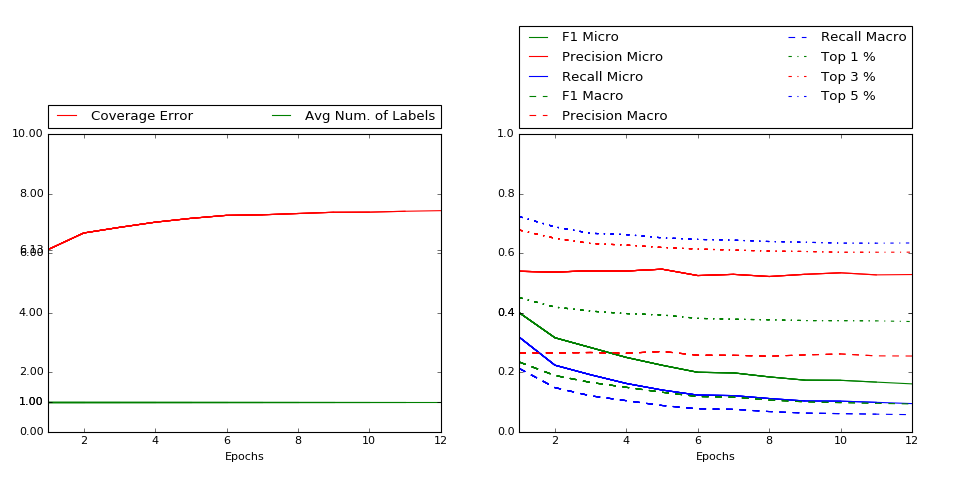

2016-12-29 04:30:05,355 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_300_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_1 *******************
2016-12-29 04:30:05,356 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_300_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_1/model
2016-12-29 04:30:05,961 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_300_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_1/model.docvecs.* with mmap=None
2016-12-29 04:30:05,964 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/sample_0.01/doc2vec_size_300_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_1/model.docvecs.doctag_syn0.npy with mmap=None
2016-12-29 04:30:06,005 : INFO : loading syn1neg from

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 04:30:58,535 : INFO : Getting Validation Embeddings
2016-12-29 04:30:58,536 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 6.762, Avg Labels: 1.000, 
		 Top 1: 0.451, Top 3: 0.658, Top 5: 0.689, 
		 F1 Micro: 0.323, Total Pos: 16,749


2016-12-29 04:31:00,113 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [1 0 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 6.129, Avg Labels: 1.000, 
		 Top 1: 0.451, Top 3: 0.679, Top 5: 0.724, 
		 F1 Micro: 0.401, Total Pos: 9,500


2016-12-29 04:31:00,947 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 04:31:04,944 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 04:31:07,994 : INFO : capital-world: 0.0% (0/152)
2016-12-29 04:31:08,801 : INFO : currency: 0.0% (0/40)
2016-12-29 04:31:33,403 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 04:31:35,573 : INFO : family: 1.8% (2/110)
2016-12-29 04:31:46,191 : INFO : gram1-adjective-to-adverb: 1.1% (6/552)
2016-12-29 04:31:52,764 : INFO : gram2-opposite: 0.9% (3/342)
2016-12-29 04:32:18,092 : INFO : gram3-comparative: 11.3% (150/1332)
2016-12-29 04:32:32,401 : INFO : gram4-superlative: 1.3% (10/756)
2016-12-29 04:32:50,275 : INFO : gram5-present-participle: 3.5% (33/930)
2016-12-29 04:33:01,689 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 04:33:25,915 : INFO : gram7-past-tense: 2.1% (27/1260)
2016-12-29 04:33:44,634 : INFO : gram8-plural: 8.2% (81/992)
2016-12-29 04:33:58,060 : INFO : gram9-plural-verbs: 7.0% (49/702)
2016-1

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 05:02:36,895 : INFO : Getting Validation Embeddings
2016-12-29 05:02:36,896 : INFO : ===== Getting validation vectors with inference
2016-12-29 05:02:36,904 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.646, Avg Labels: 1.000, 
		 Top 1: 0.460, Top 3: 0.662, Top 5: 0.694, 
		 F1 Micro: 0.345, Total Pos: 18,180


2016-12-29 05:02:44,878 : INFO : Finished loading new batch
2016-12-29 05:05:01,905 : INFO : Finished: 999
2016-12-29 05:07:21,462 : INFO : Finished: 1999
2016-12-29 05:09:38,384 : INFO : Finished: 2999
2016-12-29 05:11:51,755 : INFO : Finished: 3999
2016-12-29 05:14:08,287 : INFO : Finished: 4999
2016-12-29 05:16:25,851 : INFO : Finished: 5999
2016-12-29 05:18:37,367 : INFO : Finished: 6999
2016-12-29 05:20:49,273 : INFO : Finished: 7999
2016-12-29 05:23:04,957 : INFO : Finished: 8999
2016-12-29 05:25:18,472 : INFO : Finished: 9999
2016-12-29 05:25:20,079 : INFO : Loading new batch for index: 10000
2016-12-29 05:25:21,760 : INFO : Finished loading new batch
2016-12-29 05:27:38,742 : INFO : Finished: 10999
2016-12-29 05:29:53,952 : INFO : Finished: 11999
2016-12-29 05:29:54,223 : INFO : Loading new batch for index: 12412
2016-12-29 05:29:54,227 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 05:30:52,198 : INFO : Finished: 12412
2016-12-29 05:30:52,200 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]]
** Validation Metrics: Cov Err: 6.687, Avg Labels: 1.000, 
		 Top 1: 0.420, Top 3: 0.651, Top 5: 0.689, 
		 F1 Micro: 0.317, Total Pos: 6,715


2016-12-29 05:30:54,198 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 05:30:58,145 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 05:31:01,504 : INFO : capital-world: 0.7% (1/152)
2016-12-29 05:31:02,393 : INFO : currency: 0.0% (0/40)
2016-12-29 05:31:27,137 : INFO : city-in-state: 0.3% (4/1248)
2016-12-29 05:31:29,263 : INFO : family: 2.7% (3/110)
2016-12-29 05:31:39,919 : INFO : gram1-adjective-to-adverb: 0.4% (2/552)
2016-12-29 05:31:46,599 : INFO : gram2-opposite: 0.9% (3/342)
2016-12-29 05:32:12,474 : INFO : gram3-comparative: 10.6% (141/1332)
2016-12-29 05:32:27,103 : INFO : gram4-superlative: 1.7% (13/756)
2016-12-29 05:32:45,257 : INFO : gram5-present-participle: 7.1% (66/930)
2016-12-29 05:32:56,501 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 05:33:20,604 : INFO : gram7-past-tense: 2.1% (27/1260)
2016-12-29 05:33:39,485 : INFO : gram8-plural: 8.5% (84/992)
2016-12-29 05:33:52,831 : INFO : gram9-plural-verbs: 7.3% (51/702)
2016-1

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 06:02:04,693 : INFO : Getting Validation Embeddings
2016-12-29 06:02:04,694 : INFO : ===== Getting validation vectors with inference
2016-12-29 06:02:04,702 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.590, Avg Labels: 1.000, 
		 Top 1: 0.464, Top 3: 0.665, Top 5: 0.696, 
		 F1 Micro: 0.355, Total Pos: 18,952


2016-12-29 06:02:16,424 : INFO : Finished loading new batch
2016-12-29 06:04:31,651 : INFO : Finished: 999
2016-12-29 06:06:51,233 : INFO : Finished: 1999
2016-12-29 06:09:07,294 : INFO : Finished: 2999
2016-12-29 06:11:20,533 : INFO : Finished: 3999
2016-12-29 06:13:37,037 : INFO : Finished: 4999
2016-12-29 06:15:52,499 : INFO : Finished: 5999
2016-12-29 06:18:02,707 : INFO : Finished: 6999
2016-12-29 06:20:13,075 : INFO : Finished: 7999
2016-12-29 06:22:27,467 : INFO : Finished: 8999
2016-12-29 06:24:39,260 : INFO : Finished: 9999
2016-12-29 06:24:40,842 : INFO : Loading new batch for index: 10000
2016-12-29 06:24:41,975 : INFO : Finished loading new batch
2016-12-29 06:26:58,240 : INFO : Finished: 10999
2016-12-29 06:29:12,000 : INFO : Finished: 11999
2016-12-29 06:29:12,274 : INFO : Loading new batch for index: 12412
2016-12-29 06:29:12,278 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 06:30:09,461 : INFO : Finished: 12412
2016-12-29 06:30:09,464 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 6.876, Avg Labels: 1.000, 
		 Top 1: 0.406, Top 3: 0.633, Top 5: 0.668, 
		 F1 Micro: 0.284, Total Pos: 5,717


2016-12-29 06:30:11,209 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 06:30:16,208 : INFO : capital-common-countries: 1.3% (2/156)
2016-12-29 06:30:20,545 : INFO : capital-world: 1.3% (2/152)
2016-12-29 06:30:21,465 : INFO : currency: 0.0% (0/40)
2016-12-29 06:30:49,413 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 06:30:51,597 : INFO : family: 3.6% (4/110)
2016-12-29 06:31:02,462 : INFO : gram1-adjective-to-adverb: 1.1% (6/552)
2016-12-29 06:31:09,181 : INFO : gram2-opposite: 1.8% (6/342)
2016-12-29 06:31:35,294 : INFO : gram3-comparative: 12.6% (168/1332)
2016-12-29 06:31:49,953 : INFO : gram4-superlative: 2.4% (18/756)
2016-12-29 06:32:08,120 : INFO : gram5-present-participle: 6.5% (60/930)
2016-12-29 06:32:19,873 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 06:32:44,498 : INFO : gram7-past-tense: 2.1% (26/1260)
2016-12-29 06:33:03,861 : INFO : gram8-plural: 8.7% (86/992)
2016-12-29 06:33:17,435 : INFO : gram9-plural-verbs: 5.4% (38/702)
2016-1

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 07:01:15,641 : INFO : Getting Validation Embeddings
2016-12-29 07:01:15,643 : INFO : ===== Getting validation vectors with inference
2016-12-29 07:01:15,653 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.544, Avg Labels: 1.000, 
		 Top 1: 0.467, Top 3: 0.666, Top 5: 0.698, 
		 F1 Micro: 0.363, Total Pos: 19,476


2016-12-29 07:01:23,714 : INFO : Finished loading new batch
2016-12-29 07:03:39,669 : INFO : Finished: 999
2016-12-29 07:05:58,398 : INFO : Finished: 1999
2016-12-29 07:08:14,107 : INFO : Finished: 2999
2016-12-29 07:10:25,883 : INFO : Finished: 3999
2016-12-29 07:12:42,256 : INFO : Finished: 4999
2016-12-29 07:14:58,782 : INFO : Finished: 5999
2016-12-29 07:17:09,790 : INFO : Finished: 6999
2016-12-29 07:19:20,428 : INFO : Finished: 7999
2016-12-29 07:21:36,435 : INFO : Finished: 8999
2016-12-29 07:23:50,560 : INFO : Finished: 9999
2016-12-29 07:23:52,252 : INFO : Loading new batch for index: 10000
2016-12-29 07:23:54,125 : INFO : Finished loading new batch
2016-12-29 07:26:10,548 : INFO : Finished: 10999
2016-12-29 07:28:28,060 : INFO : Finished: 11999
2016-12-29 07:28:28,371 : INFO : Loading new batch for index: 12412
2016-12-29 07:28:28,377 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 07:29:26,116 : INFO : Finished: 12412
2016-12-29 07:29:26,118 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 7.050, Avg Labels: 1.000, 
		 Top 1: 0.398, Top 3: 0.628, Top 5: 0.663, 
		 F1 Micro: 0.251, Total Pos: 4,852


2016-12-29 07:29:28,016 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 07:29:31,887 : INFO : capital-common-countries: 0.6% (1/156)
2016-12-29 07:29:35,284 : INFO : capital-world: 0.7% (1/152)
2016-12-29 07:29:36,177 : INFO : currency: 0.0% (0/40)
2016-12-29 07:30:01,233 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 07:30:03,745 : INFO : family: 7.3% (8/110)
2016-12-29 07:30:16,581 : INFO : gram1-adjective-to-adverb: 1.4% (8/552)
2016-12-29 07:30:24,895 : INFO : gram2-opposite: 2.0% (7/342)
2016-12-29 07:30:52,412 : INFO : gram3-comparative: 14.3% (190/1332)
2016-12-29 07:31:06,832 : INFO : gram4-superlative: 1.6% (12/756)
2016-12-29 07:31:24,630 : INFO : gram5-present-participle: 6.2% (58/930)
2016-12-29 07:31:35,862 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 07:31:59,908 : INFO : gram7-past-tense: 2.1% (27/1260)
2016-12-29 07:32:18,668 : INFO : gram8-plural: 11.6% (115/992)
2016-12-29 07:32:32,034 : INFO : gram9-plural-verbs: 7.3% (51/702)
2016

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 08:01:13,490 : INFO : Getting Validation Embeddings
2016-12-29 08:01:13,491 : INFO : ===== Getting validation vectors with inference
2016-12-29 08:01:13,500 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.492, Avg Labels: 1.000, 
		 Top 1: 0.471, Top 3: 0.668, Top 5: 0.700, 
		 F1 Micro: 0.372, Total Pos: 20,068


2016-12-29 08:01:21,680 : INFO : Finished loading new batch
2016-12-29 08:03:39,759 : INFO : Finished: 999
2016-12-29 08:06:00,088 : INFO : Finished: 1999
2016-12-29 08:08:17,542 : INFO : Finished: 2999
2016-12-29 08:10:32,770 : INFO : Finished: 3999
2016-12-29 08:12:51,278 : INFO : Finished: 4999
2016-12-29 08:15:10,046 : INFO : Finished: 5999
2016-12-29 08:17:23,362 : INFO : Finished: 6999
2016-12-29 08:19:36,721 : INFO : Finished: 7999
2016-12-29 08:21:55,108 : INFO : Finished: 8999
2016-12-29 08:24:11,089 : INFO : Finished: 9999
2016-12-29 08:24:12,752 : INFO : Loading new batch for index: 10000
2016-12-29 08:24:14,771 : INFO : Finished loading new batch
2016-12-29 08:26:32,434 : INFO : Finished: 10999
2016-12-29 08:28:46,309 : INFO : Finished: 11999
2016-12-29 08:28:46,601 : INFO : Loading new batch for index: 12412
2016-12-29 08:28:46,606 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 08:29:43,017 : INFO : Finished: 12412
2016-12-29 08:29:43,019 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 7.179, Avg Labels: 1.000, 
		 Top 1: 0.393, Top 3: 0.620, Top 5: 0.652, 
		 F1 Micro: 0.224, Total Pos: 4,151


2016-12-29 08:29:45,020 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 08:29:48,858 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 08:29:52,177 : INFO : capital-world: 0.7% (1/152)
2016-12-29 08:29:53,067 : INFO : currency: 0.0% (0/40)
2016-12-29 08:30:23,661 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 08:30:26,130 : INFO : family: 7.3% (8/110)
2016-12-29 08:30:37,396 : INFO : gram1-adjective-to-adverb: 2.0% (11/552)
2016-12-29 08:30:44,167 : INFO : gram2-opposite: 0.6% (2/342)
2016-12-29 08:31:10,016 : INFO : gram3-comparative: 14.3% (191/1332)
2016-12-29 08:31:24,685 : INFO : gram4-superlative: 2.0% (15/756)
2016-12-29 08:31:42,806 : INFO : gram5-present-participle: 5.7% (53/930)
2016-12-29 08:31:54,181 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 08:32:18,416 : INFO : gram7-past-tense: 3.7% (47/1260)
2016-12-29 08:32:37,788 : INFO : gram8-plural: 10.1% (100/992)
2016-12-29 08:32:51,254 : INFO : gram9-plural-verbs: 7.7% (54/702)
201

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 09:00:45,540 : INFO : Getting Validation Embeddings
2016-12-29 09:00:45,541 : INFO : ===== Getting validation vectors with inference
2016-12-29 09:00:45,548 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.477, Avg Labels: 1.000, 
		 Top 1: 0.472, Top 3: 0.669, Top 5: 0.700, 
		 F1 Micro: 0.376, Total Pos: 20,322


2016-12-29 09:00:51,823 : INFO : Finished loading new batch
2016-12-29 09:02:56,909 : INFO : Finished: 999
2016-12-29 09:05:04,410 : INFO : Finished: 1999
2016-12-29 09:07:09,930 : INFO : Finished: 2999
2016-12-29 09:09:12,031 : INFO : Finished: 3999
2016-12-29 09:11:16,534 : INFO : Finished: 4999
2016-12-29 09:13:21,375 : INFO : Finished: 5999
2016-12-29 09:15:22,387 : INFO : Finished: 6999
2016-12-29 09:17:23,820 : INFO : Finished: 7999
2016-12-29 09:19:29,414 : INFO : Finished: 8999
2016-12-29 09:21:34,013 : INFO : Finished: 9999
2016-12-29 09:21:35,507 : INFO : Loading new batch for index: 10000
2016-12-29 09:21:37,438 : INFO : Finished loading new batch
2016-12-29 09:23:47,976 : INFO : Finished: 10999
2016-12-29 09:25:58,013 : INFO : Finished: 11999
2016-12-29 09:25:58,264 : INFO : Loading new batch for index: 12412
2016-12-29 09:25:58,268 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 09:26:53,416 : INFO : Finished: 12412
2016-12-29 09:26:53,419 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]]
** Validation Metrics: Cov Err: 7.280, Avg Labels: 1.000, 
		 Top 1: 0.382, Top 3: 0.615, Top 5: 0.647, 
		 F1 Micro: 0.201, Total Pos: 3,795


2016-12-29 09:26:55,260 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 09:26:59,064 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 09:27:02,399 : INFO : capital-world: 0.0% (0/152)
2016-12-29 09:27:03,277 : INFO : currency: 0.0% (0/40)
2016-12-29 09:27:30,509 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 09:27:32,974 : INFO : family: 8.2% (9/110)
2016-12-29 09:27:45,043 : INFO : gram1-adjective-to-adverb: 2.0% (11/552)
2016-12-29 09:27:52,491 : INFO : gram2-opposite: 0.9% (3/342)
2016-12-29 09:28:21,763 : INFO : gram3-comparative: 14.8% (197/1332)
2016-12-29 09:28:38,131 : INFO : gram4-superlative: 2.2% (17/756)
2016-12-29 09:28:58,707 : INFO : gram5-present-participle: 6.1% (57/930)
2016-12-29 09:29:11,773 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 09:29:39,636 : INFO : gram7-past-tense: 2.8% (35/1260)
2016-12-29 09:30:01,328 : INFO : gram8-plural: 10.3% (102/992)
2016-12-29 09:30:20,115 : INFO : gram9-plural-verbs: 9.0% (63/702)
201

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 09:57:50,695 : INFO : Getting Validation Embeddings
2016-12-29 09:57:50,696 : INFO : ===== Getting validation vectors with inference
2016-12-29 09:57:50,703 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.455, Avg Labels: 1.000, 
		 Top 1: 0.474, Top 3: 0.670, Top 5: 0.702, 
		 F1 Micro: 0.380, Total Pos: 20,703


2016-12-29 09:57:59,771 : INFO : Finished loading new batch
2016-12-29 10:00:14,016 : INFO : Finished: 999
2016-12-29 10:02:33,009 : INFO : Finished: 1999
2016-12-29 10:04:48,661 : INFO : Finished: 2999
2016-12-29 10:07:00,509 : INFO : Finished: 3999
2016-12-29 10:09:16,434 : INFO : Finished: 4999
2016-12-29 10:11:33,019 : INFO : Finished: 5999
2016-12-29 10:13:43,439 : INFO : Finished: 6999
2016-12-29 10:15:54,802 : INFO : Finished: 7999
2016-12-29 10:18:09,871 : INFO : Finished: 8999
2016-12-29 10:20:24,739 : INFO : Finished: 9999
2016-12-29 10:20:26,197 : INFO : Loading new batch for index: 10000
2016-12-29 10:20:27,982 : INFO : Finished loading new batch
2016-12-29 10:22:42,172 : INFO : Finished: 10999
2016-12-29 10:24:57,265 : INFO : Finished: 11999
2016-12-29 10:24:57,550 : INFO : Loading new batch for index: 12412
2016-12-29 10:24:57,556 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 10:25:54,744 : INFO : Finished: 12412
2016-12-29 10:25:54,746 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 7.298, Avg Labels: 1.000, 
		 Top 1: 0.379, Top 3: 0.611, Top 5: 0.645, 
		 F1 Micro: 0.199, Total Pos: 3,717


2016-12-29 10:25:56,461 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 10:26:00,315 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 10:26:03,753 : INFO : capital-world: 0.7% (1/152)
2016-12-29 10:26:04,647 : INFO : currency: 0.0% (0/40)
2016-12-29 10:26:32,461 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 10:26:34,944 : INFO : family: 8.2% (9/110)
2016-12-29 10:26:47,364 : INFO : gram1-adjective-to-adverb: 1.6% (9/552)
2016-12-29 10:26:55,160 : INFO : gram2-opposite: 1.5% (5/342)
2016-12-29 10:27:24,632 : INFO : gram3-comparative: 15.7% (209/1332)
2016-12-29 10:27:41,548 : INFO : gram4-superlative: 2.4% (18/756)
2016-12-29 10:28:02,821 : INFO : gram5-present-participle: 6.7% (62/930)
2016-12-29 10:28:16,043 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 10:28:44,496 : INFO : gram7-past-tense: 1.7% (22/1260)
2016-12-29 10:29:06,513 : INFO : gram8-plural: 9.9% (98/992)
2016-12-29 10:29:21,950 : INFO : gram9-plural-verbs: 9.5% (67/702)
2016-1

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 10:57:35,905 : INFO : Getting Validation Embeddings
2016-12-29 10:57:35,906 : INFO : ===== Getting validation vectors with inference
2016-12-29 10:57:35,918 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.441, Avg Labels: 1.000, 
		 Top 1: 0.474, Top 3: 0.670, Top 5: 0.701, 
		 F1 Micro: 0.381, Total Pos: 20,765


2016-12-29 10:57:43,845 : INFO : Finished loading new batch
2016-12-29 10:59:58,996 : INFO : Finished: 999
2016-12-29 11:02:07,671 : INFO : Finished: 1999
2016-12-29 11:04:14,837 : INFO : Finished: 2999
2016-12-29 11:06:18,262 : INFO : Finished: 3999
2016-12-29 11:08:25,627 : INFO : Finished: 4999
2016-12-29 11:10:33,234 : INFO : Finished: 5999
2016-12-29 11:12:35,254 : INFO : Finished: 6999
2016-12-29 11:14:38,635 : INFO : Finished: 7999
2016-12-29 11:16:44,923 : INFO : Finished: 8999
2016-12-29 11:18:49,457 : INFO : Finished: 9999
2016-12-29 11:18:50,990 : INFO : Loading new batch for index: 10000
2016-12-29 11:18:52,931 : INFO : Finished loading new batch
2016-12-29 11:21:00,839 : INFO : Finished: 10999
2016-12-29 11:23:09,821 : INFO : Finished: 11999
2016-12-29 11:23:10,157 : INFO : Loading new batch for index: 12412
2016-12-29 11:23:10,162 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 11:24:05,873 : INFO : Finished: 12412
2016-12-29 11:24:05,876 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 7.342, Avg Labels: 1.000, 
		 Top 1: 0.377, Top 3: 0.608, Top 5: 0.640, 
		 F1 Micro: 0.185, Total Pos: 3,466


2016-12-29 11:24:07,586 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 11:24:11,420 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 11:24:14,794 : INFO : capital-world: 0.7% (1/152)
2016-12-29 11:24:15,690 : INFO : currency: 0.0% (0/40)
2016-12-29 11:24:43,586 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 11:24:46,052 : INFO : family: 5.5% (6/110)
2016-12-29 11:24:58,352 : INFO : gram1-adjective-to-adverb: 1.8% (10/552)
2016-12-29 11:25:05,856 : INFO : gram2-opposite: 0.6% (2/342)
2016-12-29 11:25:35,110 : INFO : gram3-comparative: 15.9% (212/1332)
2016-12-29 11:25:51,596 : INFO : gram4-superlative: 2.2% (17/756)
2016-12-29 11:26:11,931 : INFO : gram5-present-participle: 7.5% (70/930)
2016-12-29 11:26:24,941 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 11:26:52,679 : INFO : gram7-past-tense: 2.8% (35/1260)
2016-12-29 11:27:13,949 : INFO : gram8-plural: 9.8% (97/992)
2016-12-29 11:27:29,040 : INFO : gram9-plural-verbs: 11.7% (82/702)
2016

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 11:55:35,405 : INFO : Getting Validation Embeddings
2016-12-29 11:55:35,406 : INFO : ===== Getting validation vectors with inference
2016-12-29 11:55:35,417 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.429, Avg Labels: 1.000, 
		 Top 1: 0.475, Top 3: 0.671, Top 5: 0.702, 
		 F1 Micro: 0.383, Total Pos: 20,924


2016-12-29 11:55:41,441 : INFO : Finished loading new batch
2016-12-29 11:57:57,460 : INFO : Finished: 999
2016-12-29 12:00:16,908 : INFO : Finished: 1999
2016-12-29 12:02:33,473 : INFO : Finished: 2999
2016-12-29 12:04:46,680 : INFO : Finished: 3999
2016-12-29 12:07:02,471 : INFO : Finished: 4999
2016-12-29 12:09:19,418 : INFO : Finished: 5999
2016-12-29 12:11:30,328 : INFO : Finished: 6999
2016-12-29 12:13:41,801 : INFO : Finished: 7999
2016-12-29 12:15:56,939 : INFO : Finished: 8999
2016-12-29 12:18:10,998 : INFO : Finished: 9999
2016-12-29 12:18:12,499 : INFO : Loading new batch for index: 10000
2016-12-29 12:18:13,952 : INFO : Finished loading new batch
2016-12-29 12:20:28,749 : INFO : Finished: 10999
2016-12-29 12:22:41,680 : INFO : Finished: 11999
2016-12-29 12:22:42,000 : INFO : Loading new batch for index: 12412
2016-12-29 12:22:42,005 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 12:23:37,090 : INFO : Finished: 12412
2016-12-29 12:23:37,092 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 7.383, Avg Labels: 1.000, 
		 Top 1: 0.374, Top 3: 0.607, Top 5: 0.638, 
		 F1 Micro: 0.174, Total Pos: 3,169


2016-12-29 12:23:38,814 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 12:23:42,552 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 12:23:46,001 : INFO : capital-world: 0.7% (1/152)
2016-12-29 12:23:46,870 : INFO : currency: 0.0% (0/40)
2016-12-29 12:24:14,388 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 12:24:16,900 : INFO : family: 5.5% (6/110)
2016-12-29 12:24:29,198 : INFO : gram1-adjective-to-adverb: 1.6% (9/552)
2016-12-29 12:24:36,732 : INFO : gram2-opposite: 0.3% (1/342)
2016-12-29 12:25:05,939 : INFO : gram3-comparative: 15.2% (202/1332)
2016-12-29 12:25:22,581 : INFO : gram4-superlative: 2.4% (18/756)
2016-12-29 12:25:42,929 : INFO : gram5-present-participle: 8.2% (76/930)
2016-12-29 12:25:55,628 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 12:26:23,639 : INFO : gram7-past-tense: 3.2% (40/1260)
2016-12-29 12:26:45,209 : INFO : gram8-plural: 9.4% (93/992)
2016-12-29 12:27:00,605 : INFO : gram9-plural-verbs: 10.7% (75/702)
2016-

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 12:54:14,085 : INFO : Getting Validation Embeddings
2016-12-29 12:54:14,086 : INFO : ===== Getting validation vectors with inference
2016-12-29 12:54:14,093 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.420, Avg Labels: 1.000, 
		 Top 1: 0.475, Top 3: 0.671, Top 5: 0.702, 
		 F1 Micro: 0.385, Total Pos: 21,053


2016-12-29 12:54:22,667 : INFO : Finished loading new batch
2016-12-29 12:56:35,201 : INFO : Finished: 999
2016-12-29 12:58:50,080 : INFO : Finished: 1999
2016-12-29 13:01:02,908 : INFO : Finished: 2999
2016-12-29 13:03:12,135 : INFO : Finished: 3999
2016-12-29 13:05:23,987 : INFO : Finished: 4999
2016-12-29 13:07:36,869 : INFO : Finished: 5999
2016-12-29 13:09:44,133 : INFO : Finished: 6999
2016-12-29 13:11:51,853 : INFO : Finished: 7999
2016-12-29 13:14:02,456 : INFO : Finished: 8999
2016-12-29 13:16:11,373 : INFO : Finished: 9999
2016-12-29 13:16:13,088 : INFO : Loading new batch for index: 10000
2016-12-29 13:16:15,111 : INFO : Finished loading new batch
2016-12-29 13:18:26,984 : INFO : Finished: 10999
2016-12-29 13:20:37,503 : INFO : Finished: 11999
2016-12-29 13:20:37,762 : INFO : Loading new batch for index: 12412
2016-12-29 13:20:37,766 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 13:21:32,496 : INFO : Finished: 12412
2016-12-29 13:21:32,499 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 7.387, Avg Labels: 1.000, 
		 Top 1: 0.374, Top 3: 0.604, Top 5: 0.635, 
		 F1 Micro: 0.174, Total Pos: 3,120


2016-12-29 13:21:34,372 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 13:21:38,179 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 13:21:41,573 : INFO : capital-world: 0.7% (1/152)
2016-12-29 13:21:42,447 : INFO : currency: 0.0% (0/40)
2016-12-29 13:22:09,837 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 13:22:12,227 : INFO : family: 4.5% (5/110)
2016-12-29 13:22:24,294 : INFO : gram1-adjective-to-adverb: 1.6% (9/552)
2016-12-29 13:22:31,873 : INFO : gram2-opposite: 0.6% (2/342)
2016-12-29 13:23:00,888 : INFO : gram3-comparative: 15.7% (209/1332)
2016-12-29 13:23:17,350 : INFO : gram4-superlative: 2.2% (17/756)
2016-12-29 13:23:37,562 : INFO : gram5-present-participle: 8.4% (78/930)
2016-12-29 13:23:50,172 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 13:24:17,340 : INFO : gram7-past-tense: 3.8% (48/1260)
2016-12-29 13:24:38,740 : INFO : gram8-plural: 9.2% (91/992)
2016-12-29 13:24:53,797 : INFO : gram9-plural-verbs: 11.1% (78/702)
2016-

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 13:52:22,578 : INFO : Getting Validation Embeddings
2016-12-29 13:52:22,579 : INFO : ===== Getting validation vectors with inference
2016-12-29 13:52:22,605 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.414, Avg Labels: 1.000, 
		 Top 1: 0.476, Top 3: 0.671, Top 5: 0.702, 
		 F1 Micro: 0.386, Total Pos: 21,079


2016-12-29 13:52:35,415 : INFO : Finished loading new batch
2016-12-29 13:54:47,713 : INFO : Finished: 999
2016-12-29 13:57:03,143 : INFO : Finished: 1999
2016-12-29 13:59:15,802 : INFO : Finished: 2999
2016-12-29 14:01:24,662 : INFO : Finished: 3999
2016-12-29 14:03:36,851 : INFO : Finished: 4999
2016-12-29 14:05:49,325 : INFO : Finished: 5999
2016-12-29 14:07:56,169 : INFO : Finished: 6999
2016-12-29 14:10:02,724 : INFO : Finished: 7999
2016-12-29 14:12:14,655 : INFO : Finished: 8999
2016-12-29 14:14:24,561 : INFO : Finished: 9999
2016-12-29 14:14:26,263 : INFO : Loading new batch for index: 10000
2016-12-29 14:14:27,657 : INFO : Finished loading new batch
2016-12-29 14:16:41,531 : INFO : Finished: 10999
2016-12-29 14:18:56,514 : INFO : Finished: 11999
2016-12-29 14:18:56,798 : INFO : Loading new batch for index: 12412
2016-12-29 14:18:56,803 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 14:19:54,293 : INFO : Finished: 12412
2016-12-29 14:19:54,295 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 7.417, Avg Labels: 1.000, 
		 Top 1: 0.373, Top 3: 0.604, Top 5: 0.634, 
		 F1 Micro: 0.168, Total Pos: 3,038


2016-12-29 14:19:56,057 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 14:20:00,193 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 14:20:03,601 : INFO : capital-world: 0.7% (1/152)
2016-12-29 14:20:04,501 : INFO : currency: 0.0% (0/40)
2016-12-29 14:20:31,671 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 14:20:34,151 : INFO : family: 2.7% (3/110)
2016-12-29 14:20:46,315 : INFO : gram1-adjective-to-adverb: 2.0% (11/552)
2016-12-29 14:20:53,702 : INFO : gram2-opposite: 1.2% (4/342)
2016-12-29 14:21:22,122 : INFO : gram3-comparative: 15.9% (212/1332)
2016-12-29 14:21:37,638 : INFO : gram4-superlative: 2.6% (20/756)
2016-12-29 14:21:56,854 : INFO : gram5-present-participle: 7.8% (73/930)
2016-12-29 14:22:09,033 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 14:22:35,073 : INFO : gram7-past-tense: 3.5% (44/1260)
2016-12-29 14:22:55,664 : INFO : gram8-plural: 9.4% (93/992)
2016-12-29 14:23:10,136 : INFO : gram9-plural-verbs: 10.4% (73/702)
2016

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 14:51:41,372 : INFO : Getting Validation Embeddings
2016-12-29 14:51:41,374 : INFO : ===== Getting validation vectors with inference
2016-12-29 14:51:41,383 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.398, Avg Labels: 1.000, 
		 Top 1: 0.478, Top 3: 0.671, Top 5: 0.702, 
		 F1 Micro: 0.388, Total Pos: 21,220


2016-12-29 14:51:48,894 : INFO : Finished loading new batch
2016-12-29 14:54:06,729 : INFO : Finished: 999
2016-12-29 14:56:28,896 : INFO : Finished: 1999
2016-12-29 14:58:46,982 : INFO : Finished: 2999
2016-12-29 15:01:01,233 : INFO : Finished: 3999
2016-12-29 15:03:20,270 : INFO : Finished: 4999
2016-12-29 15:05:39,777 : INFO : Finished: 5999
2016-12-29 15:07:53,731 : INFO : Finished: 6999
2016-12-29 15:10:08,111 : INFO : Finished: 7999
2016-12-29 15:12:26,136 : INFO : Finished: 8999
2016-12-29 15:14:42,538 : INFO : Finished: 9999
2016-12-29 15:14:44,261 : INFO : Loading new batch for index: 10000
2016-12-29 15:14:45,609 : INFO : Finished loading new batch
2016-12-29 15:17:03,521 : INFO : Finished: 10999
2016-12-29 15:19:19,378 : INFO : Finished: 11999
2016-12-29 15:19:19,723 : INFO : Loading new batch for index: 12412
2016-12-29 15:19:19,727 : INFO : No more batches to load, exiting at index: 12412
2016-12-29 15:20:16,823 : INFO : Finished: 12412
2016-12-29 15:20:16,827 : INFO : Fin

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 7.438, Avg Labels: 1.000, 
		 Top 1: 0.371, Top 3: 0.604, Top 5: 0.635, 
		 F1 Micro: 0.162, Total Pos: 2,903


2016-12-29 15:20:18,734 : INFO : precomputing L2-norms of word weight vectors
2016-12-29 15:20:22,571 : INFO : capital-common-countries: 0.0% (0/156)
2016-12-29 15:20:26,025 : INFO : capital-world: 0.0% (0/152)
2016-12-29 15:20:26,933 : INFO : currency: 0.0% (0/40)
2016-12-29 15:20:54,546 : INFO : city-in-state: 0.0% (0/1248)
2016-12-29 15:20:56,947 : INFO : family: 5.5% (6/110)
2016-12-29 15:21:09,168 : INFO : gram1-adjective-to-adverb: 3.1% (17/552)
2016-12-29 15:21:16,745 : INFO : gram2-opposite: 0.9% (3/342)
2016-12-29 15:21:46,102 : INFO : gram3-comparative: 15.2% (202/1332)
2016-12-29 15:22:02,957 : INFO : gram4-superlative: 2.2% (17/756)
2016-12-29 15:22:23,563 : INFO : gram5-present-participle: 7.6% (71/930)
2016-12-29 15:22:36,385 : INFO : gram6-nationality-adjective: 0.0% (0/584)
2016-12-29 15:23:04,073 : INFO : gram7-past-tense: 3.3% (41/1260)
2016-12-29 15:23:25,835 : INFO : gram8-plural: 10.2% (101/992)
2016-12-29 15:23:41,096 : INFO : gram9-plural-verbs: 10.8% (76/702)
20

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


2016-12-29 15:52:21,322 : INFO : Getting Validation Embeddings
2016-12-29 15:52:21,323 : INFO : ===== Getting validation vectors with inference
2016-12-29 15:52:21,332 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 6.388, Avg Labels: 1.000, 
		 Top 1: 0.479, Top 3: 0.673, Top 5: 0.704, 
		 F1 Micro: 0.390, Total Pos: 21,501


2016-12-29 15:52:29,150 : INFO : Finished loading new batch
2016-12-29 15:54:47,534 : INFO : Finished: 999
2016-12-29 15:57:09,901 : INFO : Finished: 1999
2016-12-29 15:59:29,448 : INFO : Finished: 2999
2016-12-29 16:01:45,265 : INFO : Finished: 3999


KeyboardInterrupt: 

In [192]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= 0.001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
    X, y = get_training_data(doc2vec_model, classifications)
    
    # try class weights
    # try warm start and evaluate after every iter
    
    info('Training Classifier')
    clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                         #alpha is the 1/C parameter
                                                         alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                         #n_jobs=-1 means use all cpus
                                                         shuffle=True, verbose=0, n_jobs=-1,
                                                         #eta0 is the learning rate when we use constant configuration
                                                         random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                         class_weight=None, warm_start=False), n_jobs=1)
    
    # Training Metrics
    clf.fit(X,y)
    info('Evaluating on Training Data')
    yp = clf.predict(X)
    print yp
    training_metrics = get_metrics(y, yp, yp)
    print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, Total Pos: {:,d}".format(
        training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
        training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
        training_metrics['f1_micro'], training_metrics['total_positive'])
    
    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_metrics.append(validation_metrics)
    
    word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
    
    word2vec_results.append(word2vec_result)
    
    
    

#     # Training and validation of SVMs using those docvecs
#     train_classifications(sections)
#     validation_vectors_matrix = get_validation_docs_with_inference(doc2vec_model, doc_classification_map)
#     metrics = do_validation(validation_vectors_matrix, doc_classification_map, sections, "sections")
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
#     print "Coverage Error: {}, Average No of Labels: {}, Top 1: {}, Top 3: {}, Top 5: {}, F1 Micro: {}, Total Positive: {}".format(
#         metrics['coverage_error'], metrics['average_num_of_labels'], metrics['top_1'], metrics['top_3'], metrics['top_5'], 
#         metrics['f1_micro'], metrics['total_positive'])
                                                                                     
#     epoch_metrics.append(metrics)
#     graph.add_metrics_to_graph(metrics, epoch)


In [75]:
from multiprocessing.dummy import Pool as ThreadPool 

In [84]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
i=0
doc_contents = []
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    doc_contents.append((doc_id, doc_contents_array))
    if i > 100:
        break

2016-12-28 22:22:21,536 : INFO : Loading new batch
2016-12-28 22:22:27,109 : INFO : Finished loading new batch


In [133]:
def infer_one_doc(doc):
    #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
    rep = doc2vec_model.infer_vector(doc[1])
    return (doc[0], rep)

Threaded Version

In [114]:
%%time
pool = ThreadPool(16)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
threaded_reps = pool.map(infer_one_doc, doc_contents)


CPU times: user 1min 41s, sys: 620 ms, total: 1min 41s
Wall time: 9.83 s


Non-Threaded Version

In [112]:
%%time
reps = []
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
for doc in doc_contents:
    reps.append((doc[0], doc2vec_model.infer_vector(doc[1])))

CPU times: user 14 s, sys: 44 ms, total: 14.1 s
Wall time: 13.9 s


In [92]:
[d[0] for d in threaded_reps][:20]

[u'08825480',
 u'08774433',
 u'08791071',
 u'08912011',
 u'08678092',
 u'08859194',
 u'08635554',
 u'08914715',
 u'08740442',
 u'08740792',
 u'08741891',
 u'08889791',
 u'08845058',
 u'08675352',
 u'08910298',
 u'08908470',
 u'07336611',
 u'07370801',
 u'08923495',
 u'08730828']

In [94]:
[d[0] for d in reps][:20]

[u'08825480',
 u'08774433',
 u'08791071',
 u'08912011',
 u'08678092',
 u'08859194',
 u'08635554',
 u'08914715',
 u'08740442',
 u'08740792',
 u'08741891',
 u'08889791',
 u'08845058',
 u'08675352',
 u'08910298',
 u'08908470',
 u'07336611',
 u'07370801',
 u'08923495',
 u'08730828']

In [100]:
np.array_equal([d[0] for d in reps], [d[0] for d in threaded_reps])

True

In [113]:
reps[0][1]

array([ 0.30695215,  0.62732637, -0.16665867,  0.21510798, -0.31053102,
        0.24912256,  0.27854046, -0.18195362, -0.2556676 , -0.5964365 ,
        0.21105912, -0.23973639, -0.03185667, -0.07150706,  0.34752986,
       -0.10195051, -0.21096784, -0.16357803, -0.36328176,  0.69572109,
        0.56532162, -0.2350243 ,  0.29052514,  0.08191228,  0.35617095,
       -0.04608935, -0.22245102, -0.2092436 ,  0.03193387,  0.20119652,
        0.41143674, -0.00198068,  0.2738685 ,  0.53701001, -0.1117554 ,
       -0.03540101, -0.34937236, -0.79319656, -0.24756837,  0.25518459,
       -0.13143119, -0.28934225,  0.40138   , -0.98963302,  0.13317154,
       -0.78089136,  0.02822817,  0.09919885,  0.06839398,  1.14812255,
       -0.35712692,  0.03212974,  0.31967002,  0.01885306,  0.32403627,
        0.06881366, -0.36663699, -0.06164655, -0.50977266,  0.13202219,
        0.34584206, -0.23481339, -0.26995379, -0.05701207,  0.09176121,
        0.05095135, -0.33242008,  0.24291369,  0.01117826,  0.10

In [116]:
threaded_reps[0][1]

array([ 0.44398868,  0.72295773, -0.1431679 ,  0.12140259, -0.35566956,
        0.25285348,  0.25987589, -0.25635543, -0.27375746, -0.68261814,
        0.2418227 , -0.31993562, -0.04068605, -0.19011304,  0.25827357,
       -0.23827454, -0.14665996, -0.24676035, -0.31205919,  0.7144047 ,
        0.51341397, -0.27819353,  0.2297533 ,  0.21143083,  0.21526954,
       -0.12819654, -0.23137507, -0.18031113, -0.0302615 ,  0.25606248,
        0.46331209,  0.03231328,  0.29240945,  0.55419838, -0.08406049,
       -0.02534914, -0.30697635, -0.89490503, -0.25361407, -0.0620365 ,
       -0.10279118, -0.24122375,  0.2858358 , -0.89883715,  0.2349384 ,
       -0.77614403,  0.07704009,  0.00219567,  0.05001302,  1.00935435,
       -0.43593982,  0.03736721,  0.49705869, -0.04218138,  0.37695912,
        0.0875724 , -0.41761422,  0.01351045, -0.63688326,  0.19897321,
        0.29641187, -0.23571339, -0.14795278, -0.12061672,  0.1306804 ,
        0.2521036 , -0.36068025,  0.26970887, -0.00897445,  0.17

In [121]:
import itertools

Simple threading, but problem is that pool.map exhausts the whole iterable

In [120]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(16)
threaded_reps = pool.map(infer_one_doc, validation_docs_iterator)

2016-12-28 23:52:07,981 : INFO : Loading new batch for index: 0


CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 26.4 ms


2016-12-28 23:52:14,764 : INFO : Finished loading new batch
2016-12-28 23:52:16,320 : INFO : Loading new batch for index: 10000
2016-12-28 23:52:36,742 : INFO : Finished loading new batch
2016-12-28 23:52:37,438 : INFO : Loading new batch for index: 12412
2016-12-28 23:52:37,487 : INFO : No more batches to load, exiting at index: 12412


More advanced threading

In [140]:
def nothing_func(doc):
    1 + 1

In [158]:
%%time
validation_docs_iterator = DocumentBatchGenerator2(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
generator_func = validation_docs_iterator.__iter__()
pool = ThreadPool(16)
# map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
threaded_reps = {}
mini_batch_size = 1000
while True:
    threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
    info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
    if threaded_reps_partial:
        #threaded_reps.extend(threaded_reps_partial)
        threaded_reps.update(threaded_reps_partial)
    else:
        break

2016-12-29 02:08:42,347 : INFO : Loading new batch for index: 0
2016-12-29 02:08:49,943 : INFO : Finished loading new batch
2016-12-29 02:09:13,387 : INFO : Finished: 1000
2016-12-29 02:09:36,895 : INFO : Finished: 2000


KeyboardInterrupt: 

In [154]:
class DocumentBatchGenerator2(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        self.curr_index += 1
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    self.curr_index += 1
                    yield doc_id, tokens


In [139]:
len(validation_docs_list)

12412

In [138]:
len(threaded_reps)

13000

In [ ]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(20)
# map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
threaded_reps = []
mini_batch_size = 1000
while True:
    threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(validation_docs_iterator, mini_batch_size))
    info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
    if threaded_reps_partial:
        threaded_reps.extend(threaded_reps_partial)
    else:
        break

In [126]:
def g():
    for el in xrange(50):
        yield el

go = g()
result = []
N = 10
for i in itertools.islice(go, N):
    print i

0
1
2
3
4
5
6
7
8
9


In [73]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
i = 0
val_docs_reps = {}
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    %time val_docs_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array, steps=15)
    if i > 2:
        break
    
print val_docs_reps

2016-12-28 18:35:17,009 : INFO : Loading new batch
2016-12-28 18:35:21,915 : INFO : Finished loading new batch


CPU times: user 848 ms, sys: 8 ms, total: 856 ms
Wall time: 852 ms
CPU times: user 448 ms, sys: 12 ms, total: 460 ms
Wall time: 457 ms
CPU times: user 248 ms, sys: 4 ms, total: 252 ms
Wall time: 250 ms
{u'08774433': array([-0.24957576, -0.44971526, -0.56399536,  0.26340374, -0.72280848,
        0.07701001,  0.53518784,  0.47400331,  0.00103833, -0.21523826,
        0.5090881 , -0.66132861, -0.54403561,  0.44076878,  0.00470332,
       -0.60674977,  0.25171441,  0.01955804, -0.42058256,  0.12502177,
       -0.16908602, -0.77621526,  0.66039973,  0.22638585, -0.14937432,
        0.18073724, -0.22520301, -0.01612019, -0.94866085, -0.56705993,
       -0.31372947, -0.61444628,  0.36096638,  0.05321291,  0.31520829,
       -0.78794104, -0.02634728,  0.27075273, -0.69757801, -0.11887208,
        0.24548931, -0.37358913,  0.30241317, -0.02301121, -0.16444607,
        0.32210201, -0.49894542,  0.47786587, -0.7696104 ,  0.57316011,
        0.75851572, -0.29875955, -0.39299953,  0.29592195,  0.01

In [196]:
X, y = get_training_data(doc2vec_model, classifications)

In [202]:
yc = np.array(y)

In [203]:
yc.shape

(49789, 8)

In [ ]:
from sklearn.svm import SVC

In [219]:
clf = OneVsRestClassifier(estimator=linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                         #alpha is the 1/C parameter
                                                         alpha=0.001, fit_intercept=True, n_iter=10,
                                                         #n_jobs=-1 means use all cpus
                                                         shuffle=True, verbose=1, epsilon=0.1, n_jobs=-1,
                                                         #eta0 is the learning rate when we use constant configuration
                                                         random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                         class_weight=None, warm_start=False), n_jobs=1)

# clf = OneVsRestClassifier(estimator=SVC(kernel='linear'), n_jobs=-1)

In [222]:
yp = clf.predict(X)

print yp

training_metrics = get_metrics(np.array(y), yp, yp)

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]]


/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predic

In [173]:
import numpy as np
from sklearn import linear_model
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array(['a', 'a', 'b', 'b'])
clf = linear_model.SGDClassifier()
clf.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [ ]:
clf.predict([[-0.8, -1]])

In [26]:
best_svm_epoch = 13

In [29]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(best_svm_epoch)
doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2016-11-26 18:25:14,192 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model
2016-11-26 18:25:14,584 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.* with mmap=None
2016-11-26 18:25:14,585 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.doctag_syn0.npy with mmap=None
2016-11-26 18:25:14,814 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.syn1neg.npy with mmap

#### Prepare Training Data

In [31]:
%%time
classifications = sections

NN_OUTPUT_NEURONS = len(classifications)
one_hot_encoder = OneHotEncoder(classifications)
training_data = []
training_labels = []
for doc_id in training_docs_list:
    # converting from memmap to a normal array
    normal_array = []
    normal_array[:] = doc2vec_model.docvecs[doc_id][:]
    training_data.append(normal_array)
    eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
    training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

CPU times: user 1.61 s, sys: 520 ms, total: 2.13 s
Wall time: 1.93 s


#### Prepare Validation Data

In [32]:
%%time

validation_labels = []
validation_data = pickle.load(open(
        os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)
))
print validation_data.shape

for validation_doc_id in validation_docs_list:
    eligible_classifications = [clssf for clssf in doc_classification_map[validation_doc_id] if clssf in classifications]
    validation_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

(1969, 3000)
CPU times: user 2.58 s, sys: 360 ms, total: 2.94 s
Wall time: 2.93 s


#### Create Keras NN

In [173]:
import itertools
from keras.layers import Dropout

In [ ]:
%%time
history_list = []
hidden_layer_sizes = [500,1500,3000,4500,6000]
activations = ['relu','sigmoid', 'tanh', 'linear', 'softmax']
input_dropout_options = [False, True]
hidden_dropout_options = [False, True]

params = list(itertools.product(hidden_layer_sizes, activations, input_dropout_options, hidden_dropout_options))
for layer_size, activation_func, input_dropout_do, hidden_dropout_do in params:
    print "===================================================================================\n" + \
          "========== Layer Size: {}, Activation: {}, Input Dropout: {}, Hidden Dropout: {} ==========================""".format(layer_size, activation_func, input_dropout_do, hidden_dropout_do)
    doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(layer_size, activation=activation_func, name='hidden_layer_{}'.format(activation_func))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                  metrics=['accuracy', 'fbeta_score', theano_coverage_error])
    model.summary()
    history = model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=NN_EPOCHS, verbose=0)
    history_list.append(history)

========== Layer Size: 500, Activation: relu, Input Dropout: False, Hidden Dropout: False ==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           1500500     doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             4008        hidden_layer_relu[0][0]          
Total params: 1504508
____________________________________________________________________________________________________
========== Layer Size: 500, Activation: relu, Input D

In [186]:
pickle.dump(history_list, open('/mnt/data2/shalaby/history_list_sample_0.0001.pickle','w'))

In [181]:
print len(history_list)

100


In [185]:
for history in history_list:
    hist = history.history
    max_val_fbeta = max(hist['val_coverage error'])
    print max_val_fbeta

2.66835957339
2.51193499238
2.40680548502
2.281361097
2.76536312849
2.42001015744
2.3844591163
2.3092940579
3.03910614525
2.50482478415
2.52412392077
2.38547486034
2.89588623667
2.85017775521
2.46267140681
2.45962417471
2.91010665312
2.81513458608
3.01218892839
3.13052310818
2.61097003555
2.64144235653
2.39918740477
2.29456576943
2.89893346877
2.5876079228
2.49212798375
2.42153377349
3.01422041646
2.63484002031
2.50837988827
2.39969527679
2.87455561199
2.94261046216
2.50431691214
2.52615540884
2.71203656679
2.96901980701
2.96597257491
3.17013712544
2.81665820213
2.87760284408
2.39918740477
2.3001523616
3.03098019299
2.67394616557
2.64347384459
2.6719146775
2.95226003047
2.68359573388
2.50279329609
2.49771457593
2.89233113255
2.9939055358
2.54647028949
2.63941086846
2.93143727781
2.97206703911
3.06094464195
3.22346368715
2.93905535805
3.12341289995
2.39969527679
2.32453021838
3.03859827324
2.76231589639
2.66124936516
2.64550533266
2.96800406298
2.75825292026
2.5281868969
2.60589131539
2

In [147]:
doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
hidden = Dense(NN_HIDDEN_NEURONS, activation='relu', name='hidden_layer')(doc_input)
softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
model = Model(input=doc_input, output=softmax_output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'fbeta_score', theano_coverage_error])

In [148]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer (Dense)             (None, 4500)          13504500    doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             36008       hidden_layer[0][0]               
Total params: 13540508
____________________________________________________________________________________________________


In [162]:
model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=1, verbose=1)

Train on 8979 samples, validate on 1969 samples
Epoch 1/1
8979/8979 [==============================] - 4s - loss: 0.0427 - acc: 0.9835 - fbeta_score: 0.9504 - coverage error: 1.4936 - val_loss: 2.1309 - val_acc: 0.8531 - val_fbeta_score: 0.4738 - val_coverage error: 3.4474


In [143]:
val_prediction = model.predict(validation_data)

In [144]:
val_prediction[:2]

array([[  2.70263344e-01,   3.49998474e-02,   3.13610617e-05,
          1.08150870e-03,   3.11665332e-07,   7.09001958e-01,
          4.97711152e-02,   2.63609409e-01],
       [  1.70166213e-02,   5.36046147e-01,   2.61311390e-04,
          4.87348643e-06,   1.27638310e-01,   9.57404263e-03,
          3.39831635e-02,   2.13784515e-03]], dtype=float32)

In [146]:
validation_labels[:2]

[[0, 0, 0, 0, 0, 0, 1, 1], [0, 1, 0, 0, 0, 0, 0, 0]]

In [124]:
y_true = T.matrix('y_true')
y_score = T.matrix('y_score')

y_score_true = y_true * y_score # mark the scores of actually true labels
zero_true_elem = T.eq(y_true, 0).nonzero()
y_score_masked = T.set_subtensor(y_score_true[zero_true_elem], 100)
#zero_elements = T.eq(true_scores,0)
min_true_scores = T.min(y_score_masked, axis=1, keepdims=True) # we do keepdims in order to keep the broadcastable columns
coverage_per_row = (y_score >= min_true_scores).sum(axis=1)
coverage = T.mean(coverage_per_row)
theano_coverage_err_func = function(inputs=[y_true, y_score], outputs=coverage)

In [109]:
uu = np.array([[1,0,1],[0,0,1]], dtype='float32')

In [118]:
yc = T.set_subtensor(y_true[T.eq(y_true,0).nonzero()], 100)

In [119]:
yc.eval({y_true: uu})

array([[   1.,  100.,    1.],
       [ 100.,  100.,    1.]], dtype=float32)

In [ ]:
T.set_subtensor(y_true[])

In [81]:
validation_labels[:1]

[[0, 0, 0, 0, 0, 0, 1, 1]]

In [82]:
val_prediction[:1]

array([[  8.08178342e-08,   1.02713175e-05,   4.41441728e-28,
          1.19779872e-36,   0.00000000e+00,   1.00000000e+00,
          2.75591228e-05,   2.31643662e-06]], dtype=float32)

In [136]:
%%time
theano_coverage_err_func(validation_labels, val_prediction)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.01 ms


array(2.5129507364144237)

In [98]:
np.multiply(validation_labels[:1] , 100) + val_prediction[:1]

array([[  8.08178342e-08,   1.02713175e-05,   4.41441728e-28,
          1.19779872e-36,   0.00000000e+00,   1.00000000e+00,
          1.00000028e+02,   1.00000002e+02]])

In [97]:
val_prediction[0,7] + 100

100.00000231643662

In [101]:
(np.multiply(validation_labels[:1] , -100) + val_prediction[:1]).min(axis=1) 

array([-99.99999768])

In [137]:
%%time
coverage_error(validation_labels, val_prediction)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.51 ms


2.5129507364144237

In [47]:
model.predict(training_data[:5])

array([[  1.43536258e-08,   2.79983366e-03,   1.15342544e-08,
          7.79373941e-17,   5.66347130e-03,   9.99988794e-01,
          6.53333089e-04,   5.85054120e-20],
       [  2.85919495e-02,   4.81873751e-02,   1.16070651e-05,
          2.11304723e-04,   9.95886266e-01,   7.23218254e-05,
          2.44005350e-03,   9.50191250e-08],
       [  1.57324195e-01,   4.55876261e-01,   1.18607618e-01,
          1.59025192e-02,   5.29134236e-02,   3.10803294e-01,
          7.60788023e-02,   4.09732945e-02],
       [  8.80629957e-01,   8.06344330e-01,   8.66507888e-01,
          8.60296586e-06,   8.48201476e-03,   3.66728357e-03,
          4.01142472e-03,   6.63176891e-09],
       [  3.67009136e-07,   2.43742179e-04,   4.91571154e-05,
          3.91778943e-16,   2.10585220e-08,   9.19317733e-03,
          2.35959844e-04,   9.99994278e-01]], dtype=float32)

In [69]:
training_labels[:5]

[[0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1]]

In [60]:
model.predict(validation_data[:5])

array([[  1.07762730e-06,   4.37068702e-05,   8.50037267e-16,
          3.26617112e-20,   5.99386426e-25,   9.99954700e-01,
          4.03022398e-08,   5.06598099e-07],
       [  7.84522370e-02,   7.51568982e-03,   3.02292941e-10,
          1.27776785e-27,   8.58146071e-01,   5.19246235e-02,
          3.96136660e-03,   9.01197339e-09],
       [  8.13455582e-01,   3.37661535e-04,   1.86206713e-01,
          2.93652289e-25,   1.42611062e-11,   8.11548398e-11,
          1.56509191e-13,   3.87454735e-10],
       [  9.48790824e-10,   4.76847440e-02,   2.83465356e-01,
          2.84471139e-27,   8.79647612e-15,   5.65862817e-15,
          4.19551939e-01,   2.49298021e-01],
       [  1.14569569e-10,   1.01953819e-12,   1.14190914e-01,
          4.46660243e-30,   3.54068044e-18,   8.85809124e-01,
          1.19672533e-14,   2.22166152e-09]], dtype=float32)

In [61]:
validation_labels[:5]

[[0, 0, 0, 0, 0, 0, 1, 1],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0]]

In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from,DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        doc2vec_model.train(sentences=StochasticDocumentGenerator(training_file, training_docs_list, line_positions), 
                            report_delay=REPORT_DELAY)
        #doc2vec_model.alpha -= 0.001  # decrease the learning rate
        #doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

#     # Training and validation of SVMs using those docvecs
#     train_classifications(sections)
#     validation_vectors_matrix = get_validation_docs_with_inference(doc2vec_model, doc_classification_map)
#     metrics = do_validation(validation_vectors_matrix, doc_classification_map, sections, "sections")
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
#     print "Coverage Error: {}, Average No of Labels: {}, Top 1: {}, Top 3: {}, Top 5: {}, F1 Micro: {}, Total Positive: {}".format(
#         metrics['coverage_error'], metrics['average_num_of_labels'], metrics['top_1'], metrics['top_3'], metrics['top_5'], 
#         metrics['f1_micro'], metrics['total_positive'])
                                                                                     
#     epoch_metrics.append(metrics)
#     graph.add_metrics_to_graph(metrics, epoch)


<IPython.core.display.Javascript object>

2016-11-27 12:06:37,744 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_1 *******************
2016-11-27 12:06:37,755 : INFO : training model with 12 workers on 243681 vocabulary and 51000 features, using sg=0 hs=0 sample=1e-05 negative=10
2016-11-27 12:06:37,756 : INFO : expecting 49789 sentences, matching count from corpus used for vocabulary survey
2016-11-27 12:07:05,285 : INFO : PROGRESS: at 0.00% examples, 40 words/s, in_qsize 23, out_qsize 0
2016-11-27 12:08:05,390 : INFO : PROGRESS: at 0.18% examples, 1894 words/s, in_qsize 24, out_qsize 0
2016-11-27 12:09:05,994 : INFO : PROGRESS: at 0.37% examples, 2579 words/s, in_qsize 24, out_qsize 0
2016-11-27 12:10:06,043 : INFO : PROGRESS: at 0.61% examples, 2862 words/s, in_qsize 24, out_qsize 0
2016-11-27 12:11:06,643 : INFO : PROGRESS: at 0.83% examples, 2995 words/s, in_qsize 24, out_qsize 0
2016-11-27 12:12:07,595 : INFO : PROGRESS: at

## Plot loaded metrics

In [48]:
doc2vec_model_save_location

'/home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001'

<IPython.core.display.Javascript object>


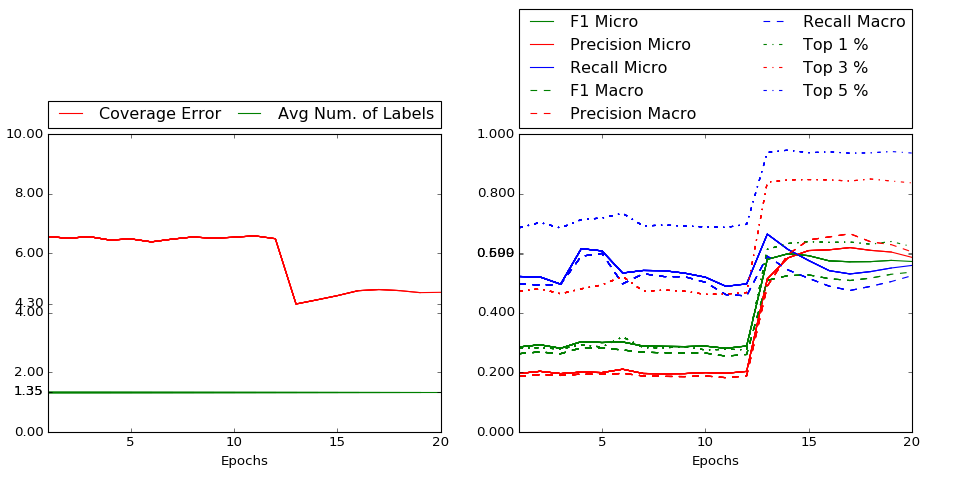

doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}_iter_1000_reg_0.001
Epoch 01: Coverage Error -> 6.56
Epoch 02: Coverage Error -> 6.51
Epoch 03: Coverage Error -> 6.56
Epoch 04: Coverage Error -> 6.45
Epoch 05: Coverage Error -> 6.49
Epoch 06: Coverage Error -> 6.39
Epoch 07: Coverage Error -> 6.48
Epoch 08: Coverage Error -> 6.55
Epoch 09: Coverage Error -> 6.51
Epoch 10: Coverage Error -> 6.54
Epoch 11: Coverage Error -> 6.59
Epoch 12: Coverage Error -> 6.50
Epoch 13: Coverage Error -> 4.30
Epoch 14: Coverage Error -> 4.44
Epoch 15: Coverage Error -> 4.58
Epoch 16: Coverage Error -> 4.75
Epoch 17: Coverage Error -> 4.79
Epoch 18: Coverage Error -> 4.75
Epoch 19: Coverage Error -> 4.68
Epoch 20: Coverage Error -> 4.69


In [32]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
print placeholder_model_name + "_" + GLOBAL_VARS.SVM_MODEL_NAME

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, GLOBAL_VARS.SVM_MODEL_NAME, METRICS)))
        print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break

In [119]:
[metric['coverage_error'] for metric in epoch_metrics]

[6.0518029456576938,
 4.3138649060436771,
 3.7851701371254443,
 1.4565769426104622,
 1.3819197562214323]